In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import csv
import pandas as pd
import numpy as np
import librosa
import os,sys

In [ ]:
ROOT_PATH='./drive/MyDrive/ASR_Project_Shared/'

## Creating a softlink to drive root, easy for relative addressing

## Guys 



relative_path = 'final_metadata/denoised/'

train_file = 'train_metadata_speech{all_clap}_noise{all_clap+noiseclips}.csv'

nb_path = './'+ train_file
os.symlink(ROOT_PATH+relative_path+'train_metadata_speech{all_clap}_noise{all_clap+noiseclips}.csv', nb_path)
sys.path.insert(0, nb_path) 

test_file_1 = 'test_metadata_speech{all_clap}_noise{qut+spam} - test_metadata_speech{all_clap}_noise{qut+spam}.csv'
nb_path = './'+ test_file_1
os.symlink(ROOT_PATH+relative_path+test_file_1, nb_path)
sys.path.insert(0, nb_path)

test_file_2 = 'test_metadata_speech{all_clap}_noise{all_clap+noiseclips+spam} - test_metadata_speech{all_clap}_noise{all_clap+noiseclips+spam}.csv'
nb_path = './'+ test_file_2
os.symlink(ROOT_PATH+relative_path+test_file_2, nb_path)
sys.path.insert(0, nb_path)


nb_path = './final_data'
os.symlink(ROOT_PATH+'final_data', nb_path)
sys.path.insert(0, nb_path) 


In [ ]:
train_df = pd.read_csv("train_metadata_speech{all_clap}_noise{all_clap+noiseclips}.csv")
test_df = pd.read_csv("test_metadata_speech{all_clap}_noise{qut+spam} - test_metadata_speech{all_clap}_noise{qut+spam}.csv")
#train_df.head()

In [ ]:
train_df_filtered = train_df
test_df_filtered = test_df
test_df_filtered.label.unique()

array([0, 1])

In [ ]:
class Config(object):
    def __init__(self,
                 sampling_rate=16000, audio_duration=2, n_classes=10, 
                 learning_rate=0.0001, max_epochs=20, n_mfcc=40):
        self.sampling_rate = sampling_rate
        self.audio_duration = audio_duration
        self.n_classes = n_classes
        self.n_mfcc = n_mfcc
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs
        self.audio_length = self.sampling_rate * self.audio_duration
        self.dim = (self.n_mfcc, 1 + int(np.floor(self.audio_length/512)), 1)


config = Config(sampling_rate=16000, audio_duration=5, learning_rate=0.0001, n_mfcc=40, n_classes=2)


In [ ]:
# Load various imports 
import pandas as pd
import os
import librosa

# Set the path to the full UrbanSound dataset 
#fulldatasetpath = '/Volumes/Untitled/ML_Data/Urban Sound/UrbanSound8K/audio/'

metadata = pd.read_csv(train_file)

x_train = np.empty(shape=(len(metadata), config.dim[0], config.dim[1], 1))
y_train = np.empty(shape =(len(metadata)))
input_length = config.audio_length

for index, row in metadata.iterrows():
  # if(index==100):
  #   break
  file_path = row['file_path']
  class_label = row["label"]
  data, _ = librosa.core.load(file_path, sr=config.sampling_rate, res_type="kaiser_fast")

  # Random offset / Padding
  if len(data) > input_length:
      max_offset = len(data) - input_length
      offset = np.random.randint(max_offset)
      data = data[offset:(input_length+offset)]
  else:
      if input_length > len(data):
          max_offset = input_length - len(data)
          offset = np.random.randint(max_offset)
      else:
          offset = 0
      data = np.pad(data, (offset, input_length - len(data) - offset), "constant")

  data = librosa.feature.mfcc(data, sr=config.sampling_rate, n_mfcc=config.n_mfcc)
  data = np.expand_dims(data, axis=-1)
  x_train[index,] = data
  y_train[index] = int(class_label)

metadata = pd.read_csv(test_file_2)

x_test = np.empty(shape=(len(metadata), config.dim[0], config.dim[1], 1))
y_test = np.empty(shape =(len(metadata)))
input_length = config.audio_length

for index, row in metadata.iterrows():
  # if(index==100):
  #   break
  file_path = row['file_path']
  class_label = row["label"]
  data, _ = librosa.core.load(file_path, sr=config.sampling_rate, res_type="kaiser_fast")

  # Random offset / Padding
  if len(data) > input_length:
      max_offset = len(data) - input_length
      offset = np.random.randint(max_offset)
      data = data[offset:(input_length+offset)]
  else:
      if input_length > len(data):
          max_offset = input_length - len(data)
          offset = np.random.randint(max_offset)
      else:
          offset = 0
      data = np.pad(data, (offset, input_length - len(data) - offset), "constant")

  data = librosa.feature.mfcc(data, sr=config.sampling_rate, n_mfcc=config.n_mfcc)
  data = np.expand_dims(data, axis=-1)
  x_test[index,] = data
  y_test[index] = int(class_label)


In [ ]:
np.shape(x_train)

(3012, 40, 157, 1)

In [ ]:
# np.shape(featuresdf['feature'][6])
# len(metadata)
# Y

array([0., 0., 0., ..., 1., 1., 1.])

In [ ]:
import pickle
path = ROOT_PATH+relative_path
pickle_out = open(path+ "CNN_test_2X"+".pkl","wb")
pickle.dump( x_test, pickle_out)
pickle_out = open(path+ "CNN_test_2Y"+".pkl","wb")
pickle.dump( y_test, pickle_out)
pickle_out = open(path+ "CNN_train_X"+".pkl","wb")
pickle.dump( x_train, pickle_out)
pickle_out = open(path+ "CNN_train_Y"+".pkl","wb")
pickle.dump( y_train, pickle_out)
pickle_out.close()

In [ ]:
def get_2d_conv_model(config):
    
    nclass = config.n_classes
    
    inp = Input(shape=(config.dim[0],config.dim[1],1))
    x = Convolution2D(32, (4,4), padding="same")(inp)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    
    x = Convolution2D(32*2, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    
    x = Convolution2D(32*3, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    
    x = Convolution2D(32*3, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)

    x = Flatten()(x)
    x = Dense(64)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    out = Dense(nclass, activation=softmax)(x)

    model = models.Model(inputs=inp, outputs=out)
    opt = optimizers.Adam(config.learning_rate)

    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    return model

In [ ]:
# np.shape(featuresdf['feature'][9])

(40, 97, 1)

In [ ]:
# import pickle
# #featuresdf =  pickle.load( open( "metadata_multi_clap_noise_marathi_bingte2.csv.pkl", "rb" ) )
# #featuresdf = featuresdf.sample(frac=1).reset_index(drop=True)
# #features_marathidf = pickle.load( open( "metadata_allspeech_noisyspeech_spamfiles.csv.pkl", "rb" ) )
# #features_marathidf = features_marathidf.sample(frac=1).reset_index(drop=True)
# from sklearn.preprocessing import LabelEncoder
# from keras.utils import to_categorical

# # Convert features and corresponding classification labels into numpy arrays
# #X = np.array(featuresdf.feature)
# y = Y#np.array(featuresdf.class_label)

# # Encode the classification labels
# le = LabelEncoder()
# yy = to_categorical(le.fit_transform(y)) 
# # split the dataset 
# from sklearn.model_selection import train_test_split 

# x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 42)

In [ ]:
x_train

array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]],


       [[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
 

In [ ]:
#CNN model 
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten,Input
from keras.activations import relu, softmax
from keras.layers import Convolution2D, MaxPooling2D , Conv2D,BatchNormalization,MaxPool2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 
from keras import losses, models, optimizers
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
#Create Keras Model
# def create_CNN_Model():

#     model = Sequential()
#     model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(40,80,1)))
#     model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.25))
#     model.add(Flatten())
#     model.add(Dense(128, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(2, activation='softmax'))

#     model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
#     print(model.summary())
#     [print(i.shape, i.dtype) for i in model.inputs]
#     [print(o.shape, o.dtype) for o in model.outputs]
#     [print(l.name, l.input_shape, l.dtype) for l in model.layers]
#     # x_test_tf = tf.convert_to_tensor(x_test, dtype=tf.float32)
#     # y_test_tf = tf.convert_to_tensor(y_test, dtype=tf.float32)
#     # y_train_tf = tf.convert_to_tensor(y_train, dtype=tf.float32)
#     # x_train_tf = tf.convert_to_tensor(x_train, dtype=tf.float32)
#     model.fit(x_train, y_train, batch_size=4, epochs=10, verbose=1, validation_data=(x_test, y_test))
#     #model.fit(x_train_tf, y_train_tf, batch_size=4, epochs=10, verbose=1, validation_data=(x_test_tf, y_test_tf))
#     return model

In [ ]:
m = get_2d_conv_model(config) 
#m= create_CNN_Model()

In [ ]:
le = LabelEncoder()
y_train = to_categorical(le.fit_transform(y_train)) 
y_test =to_categorical(le.fit_transform(y_test)) 

In [ ]:
y_train

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [ ]:
history = m.fit(x_train, y_train, 
                    validation_data=(x_test, y_test), 
                    batch_size=32,
                    epochs=4)

Epoch 1/4
141/141 [==============================] - 184s 1s/step - loss: 0.0981 - acc: 0.9631 - val_loss: 0.2430 - val_acc: 0.9169
Epoch 2/4
141/141 [==============================] - 180s 1s/step - loss: 0.0364 - acc: 0.9879 - val_loss: 0.2126 - val_acc: 0.9102
Epoch 3/4
141/141 [==============================] - 180s 1s/step - loss: 0.0156 - acc: 0.9971 - val_loss: 0.1273 - val_acc: 0.9538
Epoch 4/4
141/141 [==============================] - 184s 1s/step - loss: 0.0194 - acc: 0.9962 - val_loss: 0.1217 - val_acc: 0.9571


In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, labels):
    """
    plots the confusion matrix
    """
    matrix = confusion_matrix(y_true, y_pred)    
    fig, ax = plt.subplots(figsize=(4,3))
    plt.imshow(matrix)
    ax.set_xticks(range(len(labels)));
    ax.set_xticklabels(labels, rotation=0)
    ax.set_yticks(range(len(labels)));
    ax.set_yticklabels(labels)
    max_confusions = 0
    confused_classes = (-1, -1)
    for i, true_label in enumerate(matrix):
        for j, predicted_label in enumerate(true_label):
            text = ax.text(j, i, matrix[i, j],
                        ha="center", va="center", color="r");
    plt.tick_params(axis=u'both', which=u'both',length=0)
    plt.title("Confusion Matrix");

In [ ]:
#y_pred = (m.predict(x_test) > 0.5).astype(int)
y_pred_ = m.predict(x_test, use_multiprocessing=True, workers=6, verbose=1)

47/47 [==============================] - 14s 296ms/step


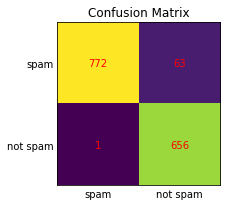

In [ ]:

y_pred = np.argmax(y_pred_, axis=1)
y_true = np.argmax(y_test, axis=1)
#labels = []_
labels =['spam','not spam']

plot_confusion_matrix(y_true, y_pred, labels)